In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

C:\Users\Franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Encoder(nn.Module):
    def __init__(self, latent_size):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # Output: [32, 14, 14]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # Output: [64, 7, 7]
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU()
        )
        self.mu = nn.Linear(128, latent_size)
        self.logvar = nn.Linear(128, latent_size)

    def encode(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return  z, mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_size):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # Output: [32, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: [1, 28, 28]
            nn.Sigmoid()
        )
    
    def decode(self, z):
        return self.decoder(z).view(-1, 1, 28, 28)
    
    def forward(self, z):
        return self.decode(z)

class VAE(nn.Module):
    def __init__(self, latent_size):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_size)
        self.decoder = Decoder(latent_size)
    
    def forward(self, x):
        z, mu, logvar = self.encoder(x)
        return self.decoder(z), mu, logvar
    
      
def loss_function(recon_x, x, mu, logvar, beta=1.0):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * beta * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [3]:
# Training the VAE
latent_dim = 2  # To visualize, we use a 2D latent space
beta = 1.0
vae = VAE(latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# DataLoader for MNIST
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

# Training loop
vae.train()
epochs = 10
losses = []
for epoch in range(epochs):
    total_loss = 0
    for x, _ in train_loader:
        # x_viewed = x.view(-1, 28 * 28) 
        optimizer.zero_grad()
        x_recon, mu, logvar = vae(x)
        loss = loss_function(x_recon, x, mu, logvar, beta)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss/len(train_data))
    print(f"Epoch {epoch + 1}, Loss: {total_loss/len(train_data):.2f}")

Epoch 1, Loss: 215.56
Epoch 2, Loss: 168.24
Epoch 3, Loss: 160.31
Epoch 4, Loss: 157.21
Epoch 5, Loss: 155.13
Epoch 6, Loss: 153.65
Epoch 7, Loss: 152.40
Epoch 8, Loss: 151.41
Epoch 9, Loss: 150.63
Epoch 10, Loss: 149.90


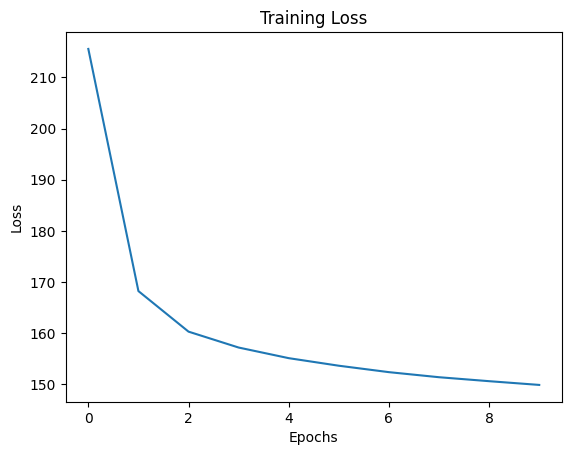

In [5]:
# Save the model
torch.save(vae.state_dict(), './models/vae_1.pth')

# Plot the loss
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

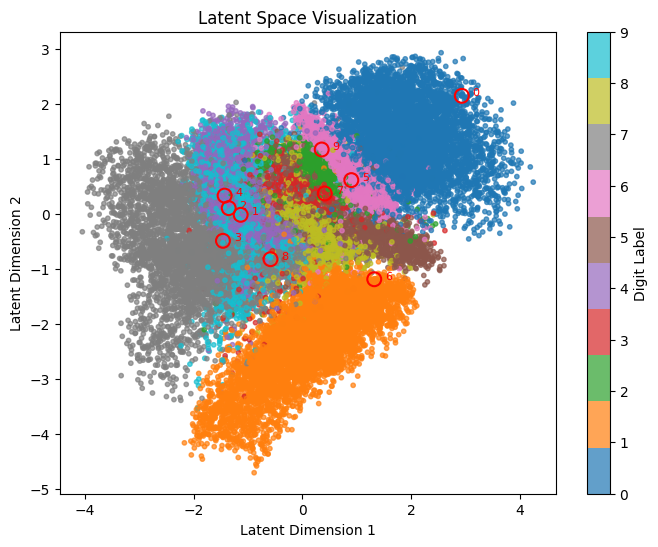

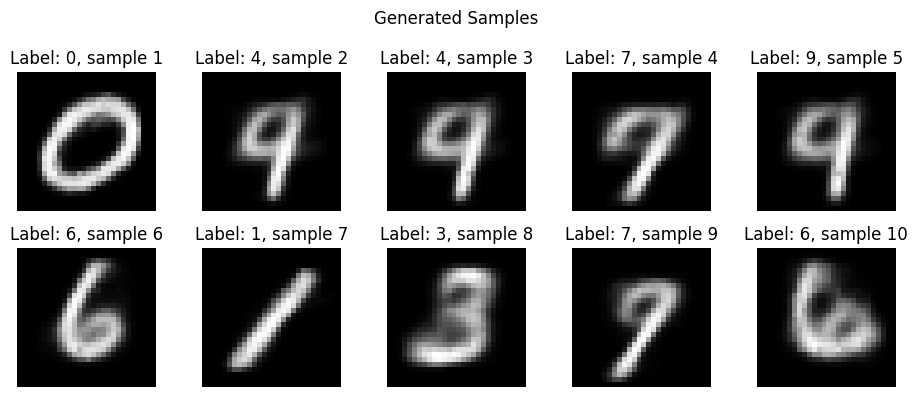

In [14]:
# Visualizing the latent space
vae.eval()
latents, labels = [], []
with torch.no_grad():
    for x, y in train_loader:
        # x = x.view(-1, 28 * 28)
        _, mu, _ = vae(x)
        latents.append(mu)
        labels.append(y)
latents = torch.cat(latents)
labels = torch.cat(labels)

decoder = vae.decoder
# Generate samples from the latent space

n_samples = 10
sample_indices = torch.randint(0, len(latents), (n_samples,))  # Sélectionner des indices aléatoires
sample_latents = latents[sample_indices]
sample_labels = labels[sample_indices]
with torch.no_grad():
    generated = decoder(sample_latents)
    generated = generated.view(-1, 28, 28).numpy()

# Scatter plot of the latent space
plt.figure(figsize=(8, 6))
scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', alpha=0.7, s=10)
plt.colorbar(scatter, label='Digit Label')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization')

# Entourer les points échantillonnés
for idx, (x, y) in enumerate(sample_latents[:, :2]):
    plt.scatter(x, y, edgecolor='red', facecolor='none', s=100, linewidth=1.5)  # Cercle rouge
    plt.text(x + 0.2, y, f'{idx}', color='red', fontsize=8)  # Annoter avec un index

plt.show()

plt.figure(figsize=(10, 4))
for i in range(n_samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(generated[i], cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'Label: {sample_labels[i].item()}, sample {i + 1}')
    plt.suptitle('Generated Samples')
plt.show()